In [ ]:
import os
kaggle_data={"username":"faustino2020","key":"a5c02d592526ba248a5afe4a9afb596a"}
os.environ['KAGGLE_USERNAME']=kaggle_data["username"]
os.environ['KAGGLE_KEY']=kaggle_data["key"]
import kaggle
!kaggle datasets download -d faustino2020/disaster

disaster.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# !unzip /content/disaster.zip


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms 
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")

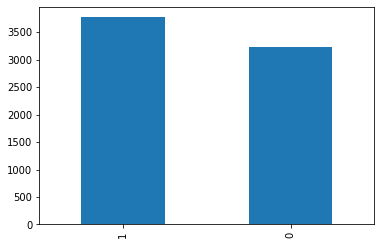

In [ ]:
train["Target"].value_counts().plot.bar()

In [ ]:
train_files = train["Image_ID"].to_numpy()
test_files = test["Image_ID"].to_numpy()
train_labels = train["Target"].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(train_files,train_labels,test_size=.2,random_state=42)

In [ ]:
import math
def plot_random_images(number: int) -> None:
    """
    get random images and plot them
    Args: int: number -> number of imaged
    return: None
    
    """
    
    grid = int(math.ceil(math.sqrt(number)))
    indexes = np.random.randint(low=0,high=len(train_files),size=number)
    for i,n in enumerate(indexes):
        plt.subplot(grid,grid,i+1)
        img = Image.open(f"Images/{train_files[n]}.tif")
        plt.imshow(img)
        plt.axis(False)

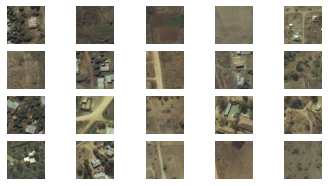

In [ ]:
plot_random_images(20)

In [ ]:
class MyDataset(Dataset):
    def __init__(self,names,labels=None,transform=None):
        self.names = names
        self.labels = labels
        self.transform = transform
        if labels is not None:
            self.labels = torch.torch.LongTensor(labels)
    def __len__(self):
        return len(self.names)
    def __getitem__(self,index):
        img = Image.open(f"Images/{self.names[index]}.tif")
        if self.transform is not None:
            img = self.transform(img)
        else:
            img =  transforms.ToTensor()(img)
        if self.labels is None:
            return img
        return img,self.labels[index]

# Transforms

In [ ]:
train_transform = transforms.Compose([
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float),
        # transforms.ColorJitter(brightness=.5, hue=.3),
        # transforms.RandomHorizontalFlip(p=0.3),
        # transforms.RandomVerticalFlip(p=0.3),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
      ])
test_transform = transforms.Compose([
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
  ])

# Create Dataset

In [ ]:
train_data = MyDataset(X_train,y_train,train_transform)
val_data = MyDataset(X_test,y_test,test_transform)
test_data = MyDataset(test_files,transform=test_transform)

# Create Dataloaders

In [ ]:
train_loader = DataLoader(train_data,batch_size=128,shuffle=True,num_workers=2,pin_memory=True)
val_loader = DataLoader(val_data,batch_size=128,shuffle=True,num_workers=2,pin_memory=True)
test_loader = DataLoader(test_data,batch_size=128,shuffle=False,num_workers=2,pin_memory=True)

In [ ]:
for x,y in train_loader:
    print(x.shape,y.shape)
    break

torch.Size([128, 3, 250, 250]) torch.Size([128])


In [ ]:
for x in test_loader:
  print(x.shape)
  break

torch.Size([128, 3, 250, 250])


# Create Model

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        #create layers
        
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=64, kernel_size=5,stride=1)
        self.b1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(4)
        self.dropout1 = nn.Dropout2d(0.2)
        
        self.conv2 = nn.Conv2d(in_channels=64,out_channels=128, kernel_size=5,stride=1)
        self.b2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(4)
        self.dropout2 = nn.Dropout2d(0.2)
        
        self.conv3 = nn.Conv2d(in_channels=128,out_channels=256, kernel_size=5,stride=1)
        self.b3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(4)
        self.dropout3 = nn.Dropout2d(0.2)
        self.flatten = nn.Flatten()
        
        self.linear1 = nn.Linear(1024,256)
        self.b4 = nn.BatchNorm1d(256)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(.2)
        
        self.linear2 = nn.Linear(256,64)
        self.b5 = nn.BatchNorm1d(64)
        self.relu5 = nn.ReLU()
        self.dropout5 = nn.Dropout(0.2)
        
        self.linear3 = nn.Linear(64,2)   
        
    def forward(self,x):
        
        x = self.conv1(x)
        x = self.b1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.b2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.dropout2(x)
        x = self.conv3(x)
        x = self.b3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        x = self.dropout3(x)
        x = self.flatten(x)
        # print(x.shape)
        x = self.linear1(x)
        x = self.b4(x)
        x = self.relu4(x)
        x = self.dropout4(x)
        x = self.linear2(x)
        x = self.b5(x)
        x = self.relu5(x)
        x = self.dropout5(x)
        x = self.linear3(x)
        return x

In [ ]:
model = Model().cuda()

#create a loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=.001)
epochs = 30

In [ ]:
def train(data_loader, optimizer,model):
    model.train()
    accuracy = []
    losses = []
    for i,(x,y) in enumerate(data_loader):
        x=x.cuda()
        y=y.cuda()
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds,y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        y_preds =preds.argmax(axis=1)
        acc = accuracy_score(y.cpu(),y_preds.cpu().detach().numpy())
        accuracy.append(acc)
    av_loss = np.mean(losses)
    av_acc = np.mean(accuracy)
    return av_loss, av_acc

def val(data_loader, optimizer,model):
    model.eval()
    accuracy = []
    losses = []
    for i, (x,y) in enumerate(data_loader):
        x= x.cuda()
        y=y.cuda()
        with torch.no_grad():
            preds = model(x)
            y_preds =preds.argmax(axis=1)
            loss = criterion(preds,y)
            acc = accuracy_score(y.cpu(),y_preds.cpu())
            accuracy.append(acc)
            losses.append(loss.item())
    av_loss = np.mean(losses)
    av_acc = np.mean(accuracy)
    return av_loss, av_acc

In [ ]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []
for i in range(epochs):
    t_loss,t_acc = train(train_loader, optimizer,model)
    l_loss,l_acc = val(val_loader, optimizer,model)
    # print(f"Epoch:{i+1}/{epochs},Training Loss:{t_loss},Train Accuracy:{t_acc}")
    print(f"Epoch:{i+1}/{epochs},Training Loss:{t_loss},Validation Loss:{l_loss},Train Accuracy:{t_acc},Validation Accuracy:{l_acc}")
    train_loss.append(t_loss)
    val_loss.append(l_loss)
    train_acc.append(t_acc)
    val_acc.append(l_acc)

Epoch:1/30,Training Loss:0.5777924697507512,Validation Loss:0.543378163467754,Train Accuracy:0.7085108901515151,Validation Accuracy:0.7319602272727272
Epoch:2/30,Training Loss:0.5427888591181148,Validation Loss:0.537907440554012,Train Accuracy:0.7294625946969696,Validation Accuracy:0.7176136363636364
Epoch:3/30,Training Loss:0.532274032858285,Validation Loss:0.5625906803391196,Train Accuracy:0.7363873106060606,Validation Accuracy:0.7072443181818181
Epoch:4/30,Training Loss:0.5244022235274315,Validation Loss:0.5721005282618783,Train Accuracy:0.7440222537878788,Validation Accuracy:0.7366003787878789
Epoch:5/30,Training Loss:0.5138065557588231,Validation Loss:0.5227622823281721,Train Accuracy:0.7523674242424242,Validation Accuracy:0.7500473484848484
Epoch:6/30,Training Loss:0.5064153650944884,Validation Loss:0.5246396254409443,Train Accuracy:0.7549124053030304,Validation Accuracy:0.7555871212121211
Epoch:7/30,Training Loss:0.49062809415838937,Validation Loss:0.5270047973502766,Train Accur

In [ ]:
class Model2(nn.Module):
    def __init__(self):
        super().__init__()
        
        #create layers
        
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=64, kernel_size=5,stride=1)
        self.b1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout2d(0.2)
        
        self.conv2 = nn.Conv2d(in_channels=64,out_channels=128, kernel_size=5,stride=1)
        self.b2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout2d(0.2)
        
        self.conv3 = nn.Conv2d(in_channels=128,out_channels=256, kernel_size=5,stride=1)
        self.b3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout2d(0.2)
        self.flatten = nn.Flatten()
        
        self.linear1 = nn.Linear(14500864,1024)
        self.b4 = nn.BatchNorm1d(1024)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(.2)
        
        self.linear2 = nn.Linear(1024,64)
        self.b5 = nn.BatchNorm1d(64)
        self.relu5 = nn.ReLU()
        self.dropout5 = nn.Dropout(0.2)
        
        self.linear3 = nn.Linear(64,2)   
        
    def forward(self,x):
        
        x = self.conv1(x)
        x = self.b1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.b2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.conv3(x)
        x = self.b3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        x = self.flatten(x)
        # print(x.shape)
        x = self.linear1(x)
        x = self.b4(x)
        x = self.relu4(x)
        x = self.dropout4(x)
        x = self.linear2(x)
        x = self.b5(x)
        x = self.relu5(x)
        x = self.dropout5(x)
        x = self.linear3(x)
        return x

In [ ]:
model2 = Model2().cuda()

#create a loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(),lr=.001)
epochs = 30

In [ ]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []
for i in range(epochs):
    t_loss,t_acc = train(train_loader, optimizer,model2)
    l_loss,l_acc = val(val_loader, optimizer,model2)
    # print(f"Epoch:{i+1}/{epochs},Training Loss:{t_loss},Train Accuracy:{t_acc}")
    print(f"Epoch:{i+1}/{epochs},Training Loss:{t_loss},Validation Loss:{l_loss},Train Accuracy:{t_acc},Validation Accuracy:{l_acc}")
    train_loss.append(t_loss)
    val_loss.append(l_loss)
    train_acc.append(t_acc)
    val_acc.append(l_acc)

torch.Size([10, 14500864])


RuntimeError: ignored

In [1]:
class Model(nn.Module):
  def __init__(self,input_features: int,output_features: int,hiddens: list) ->None:

    self.layers = []
    self.layers.append(nn.Linear(input_features,hiddens[0]))

    for i,hidden in enumerate(hiddens,1):
      input_ = hiddens[i-1]
      out = hiddens[i]
      self.layers.append(nn.Linear(input_,out))

    self.layers.append(nn.Linear(hiddens[-1],output_features))

    self.layers = nn.Sequential(self.layers)


  def forward(self,x):
    
    return self.layers()
    



NameError: ignored